<a href="https://colab.research.google.com/github/hwangho-kim/LLM-AD/blob/master/%ED%95%98%EC%9D%B4%EB%B8%8C%EB%A6%AC%EB%93%9C_FDC_%EB%B6%84%EC%84%9D_%EB%AA%A8%EB%8D%B8_Python_%EA%B5%AC%ED%98%84%EC%B2%B4_(%EC%98%81%EB%AC%B8_%EA%B7%B8%EB%9E%98%ED%94%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating sample data for 500 wafers...
Sample data generation complete.

[Generated MES Data Sample (Top 5)]
   wafer_id equipment_id recipe_id anomaly_type  final_yield
0  WAF_0001     Etcher_B  Recipe_2        Drift            0
1  WAF_0002     Etcher_B  Recipe_1        Spike            0
2  WAF_0003     Etcher_A  Recipe_1       Normal            1
3  WAF_0004     Etcher_C  Recipe_2       Normal            1
4  WAF_0005     Etcher_C  Recipe_2        Drift            0

[Normal/Anomaly Data Distribution]
anomaly_type
Normal      388
Spike        41
Drift        37
Variance     34
Name: count, dtype: int64

[Sample Data Visualization] - FDC Data for Normal and Anomaly Types


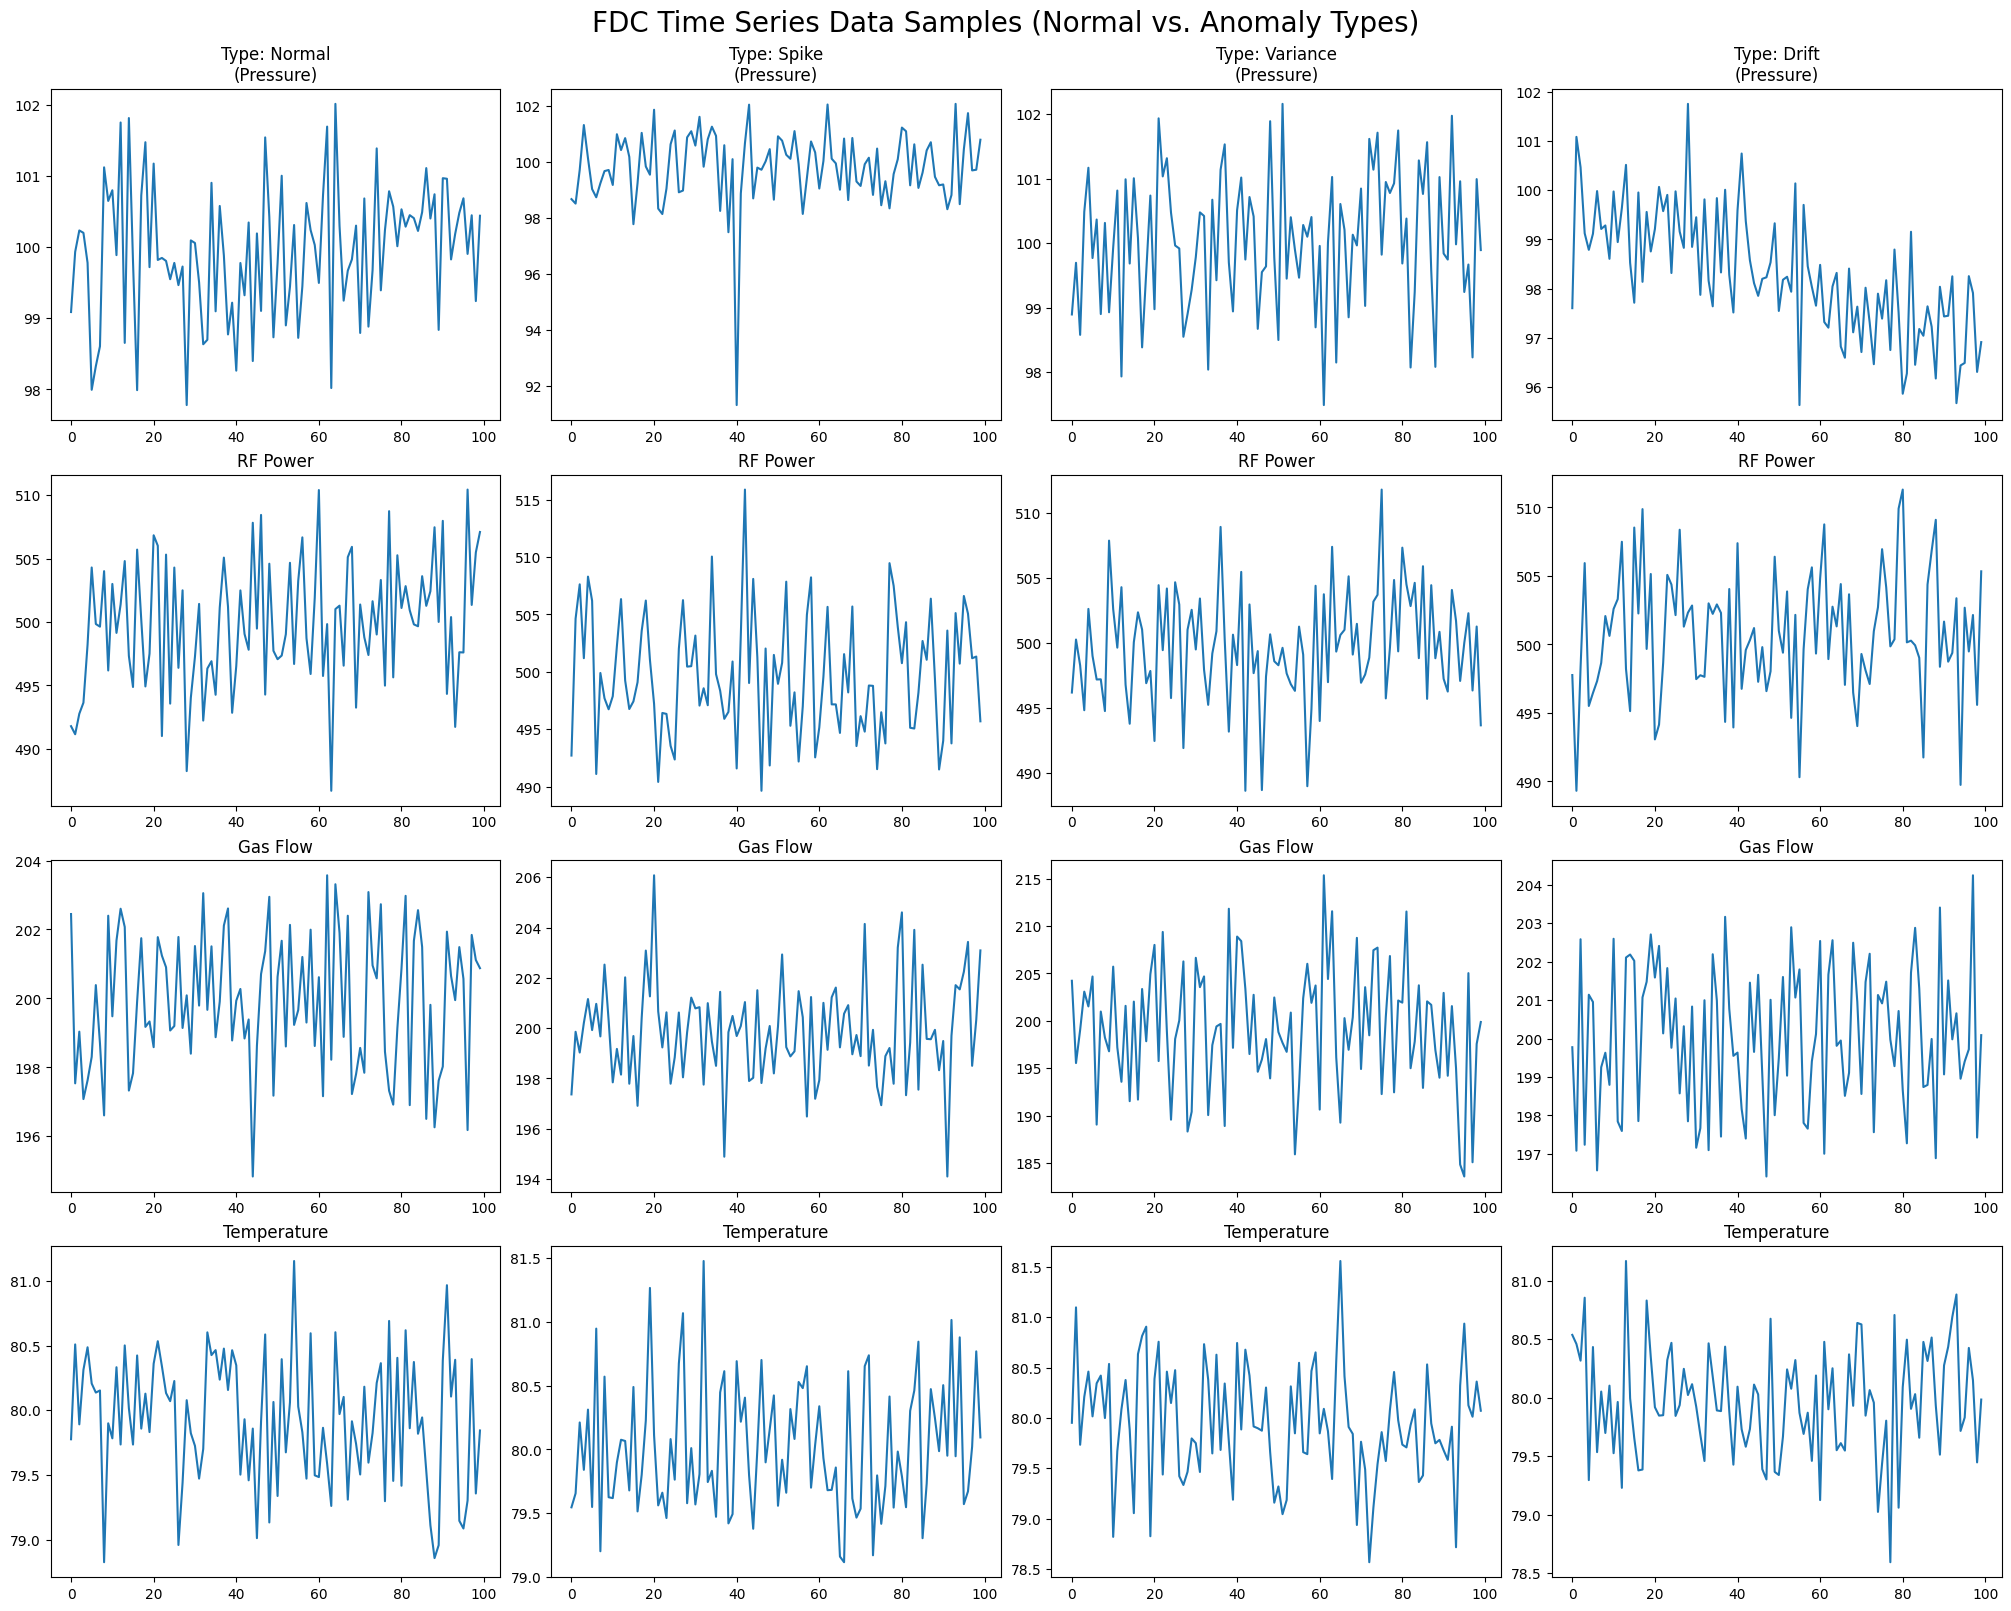


Starting time-series feature engineering...
Feature extraction complete.
Dynamic and static data integration complete.

[Final Integrated Dataset Sample (Top 5)]
   wafer_id equipment_id recipe_id anomaly_type  final_yield  pressure_mean  \
0  WAF_0001     Etcher_B  Recipe_2        Drift            0      98.306580   
1  WAF_0002     Etcher_B  Recipe_1        Spike            0      99.815729   
2  WAF_0003     Etcher_A  Recipe_1       Normal            1      99.939865   
3  WAF_0004     Etcher_C  Recipe_2       Normal            1      99.933951   
4  WAF_0005     Etcher_C  Recipe_2        Drift            0      97.962056   

   pressure_std  pressure_max  pressure_min  pressure_skew  ...  gas_flow_max  \
0      1.253714    101.754197     95.632712       0.138317  ...    204.247928   
1      1.338855    102.088152     91.328904      -2.460936  ...    206.080269   
2      0.922555    102.016628     97.778858      -0.177923  ...    203.572481   
3      0.997620    102.768998     97.7

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,124 (4.39 KB)

 Trainable params: 1,124 (4.39 KB)

 Non-trainable params: 0 (0.00 B)


Starting Autoencoder model training...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2935 - val_loss: 0.2801
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2744 - val_loss: 0.2568
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2492 - val_loss: 0.2300
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2227 - val_loss: 0.2019
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1951 - val_loss: 0.1744
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1690 - val_loss: 0.1512
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1465 - val_loss: 0.1348
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1321 - val_loss: 0.1253
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1231 - val_loss: 0.1204
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1179 - val_loss: 0.1181
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1172 - val_loss: 0.1166
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━

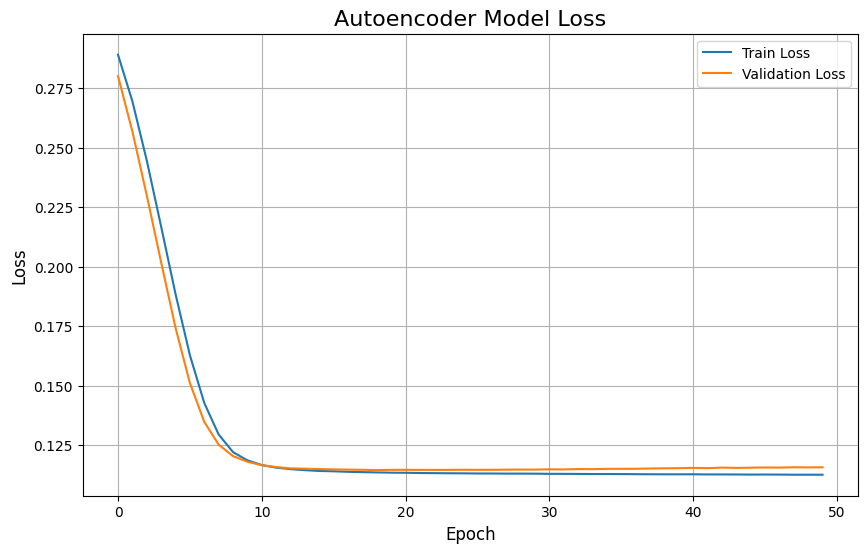

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Calculated Anomaly Detection Threshold: 0.1599


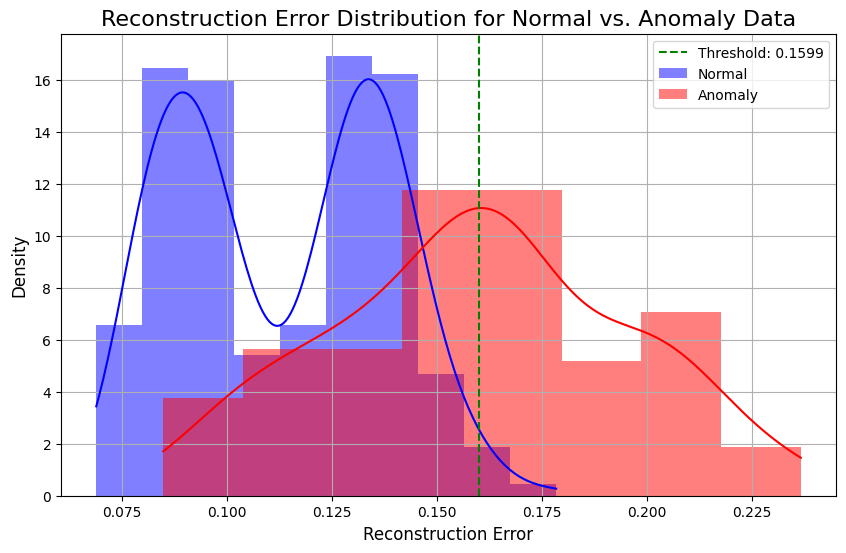


[Anomaly Detection Model Evaluation Results]
              precision    recall  f1-score   support

      Normal       0.88      0.99      0.93       388
     Anomaly       0.94      0.52      0.67       112

    accuracy                           0.88       500
   macro avg       0.91      0.75      0.80       500
weighted avg       0.89      0.88      0.87       500



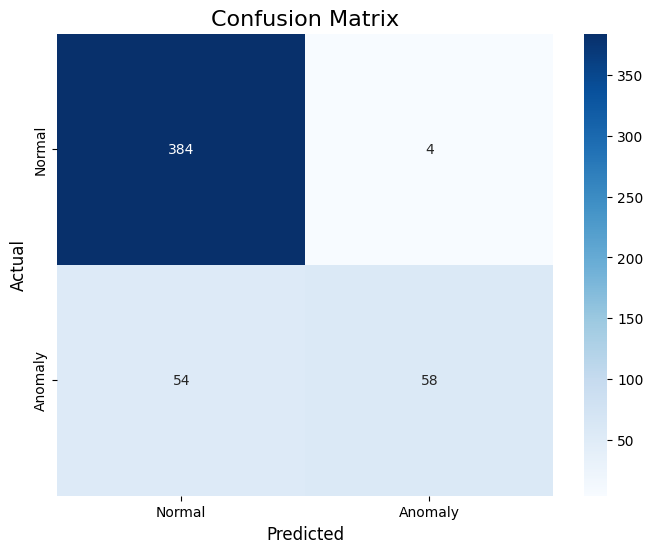

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6582/6582 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6582/6582 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6582/6582 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6582/6582 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6582/6582 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step

Starting SHAP analysis (for top 5 anomaly samples)...
SHAP Force Plot for each anomaly sample:
(The plot shows how each feature contributed to pushing the model output from the base value (the average prediction) to the model output.)
(Features pushing the prediction higher are in red, those pushing it lower are in blue.)


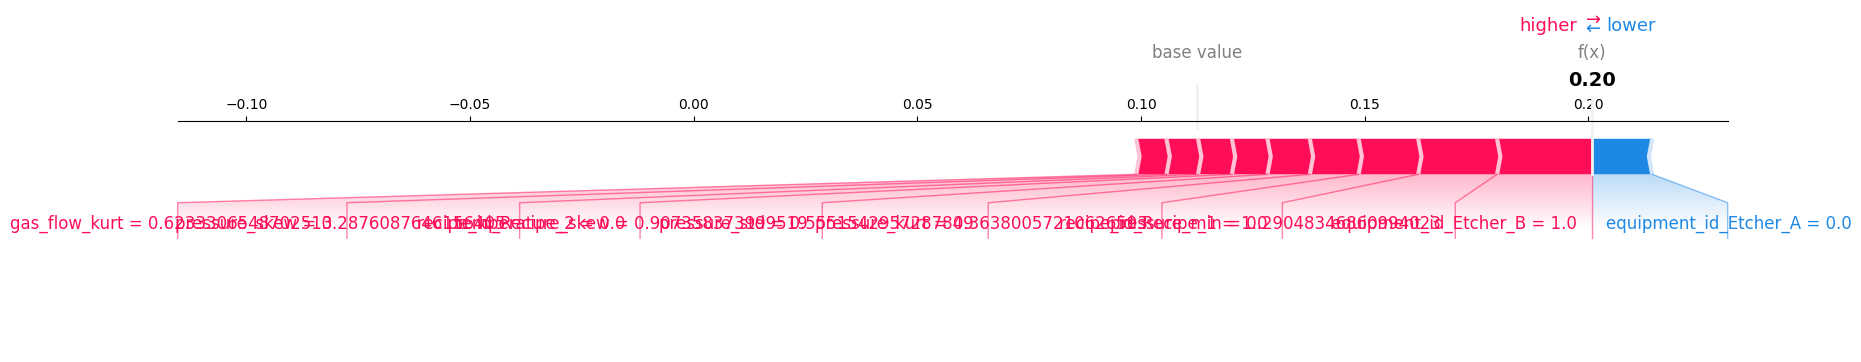

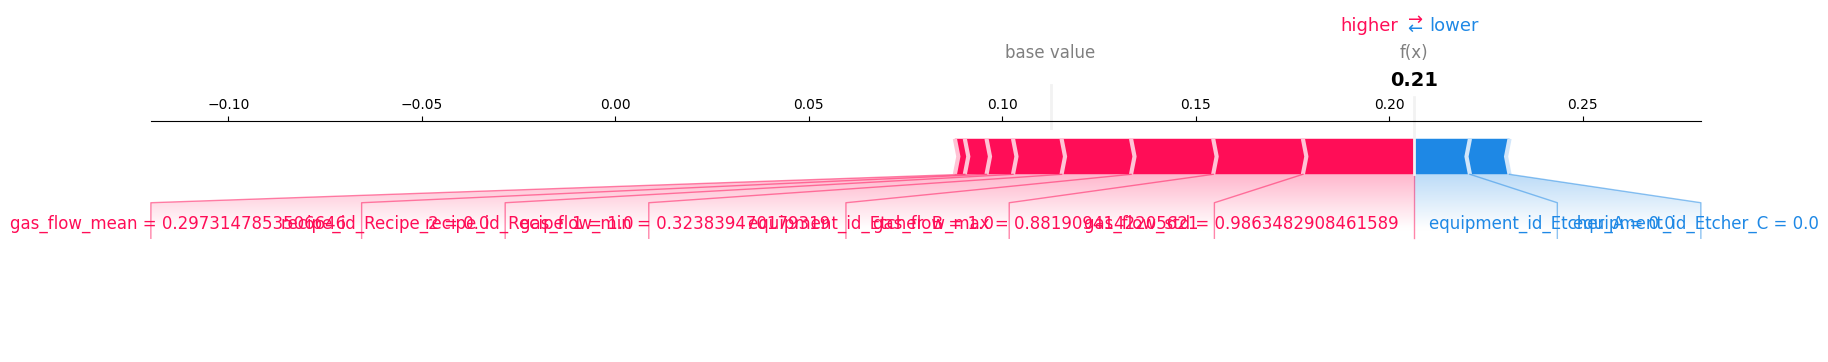

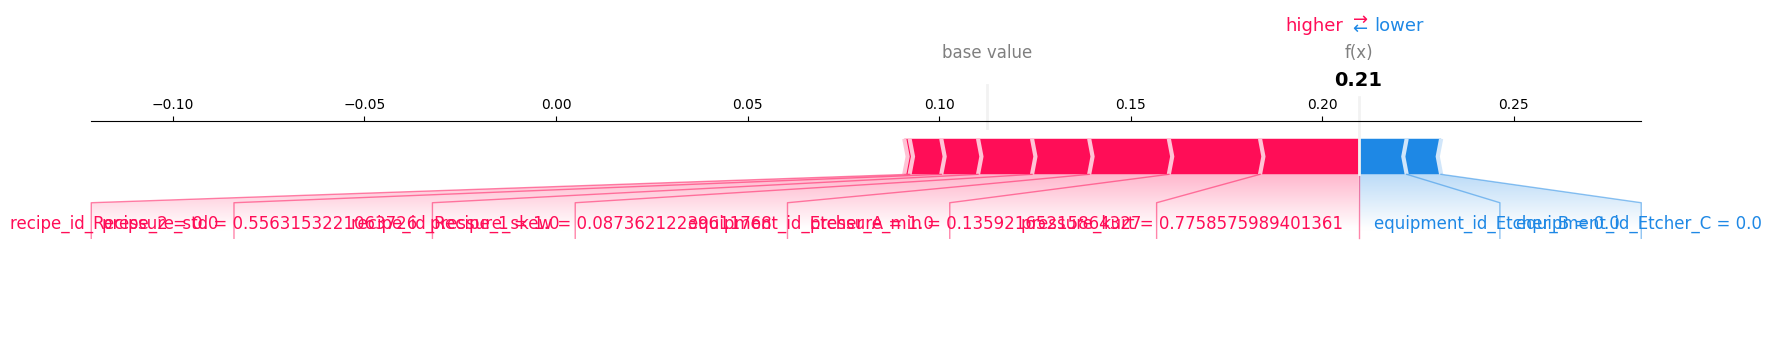

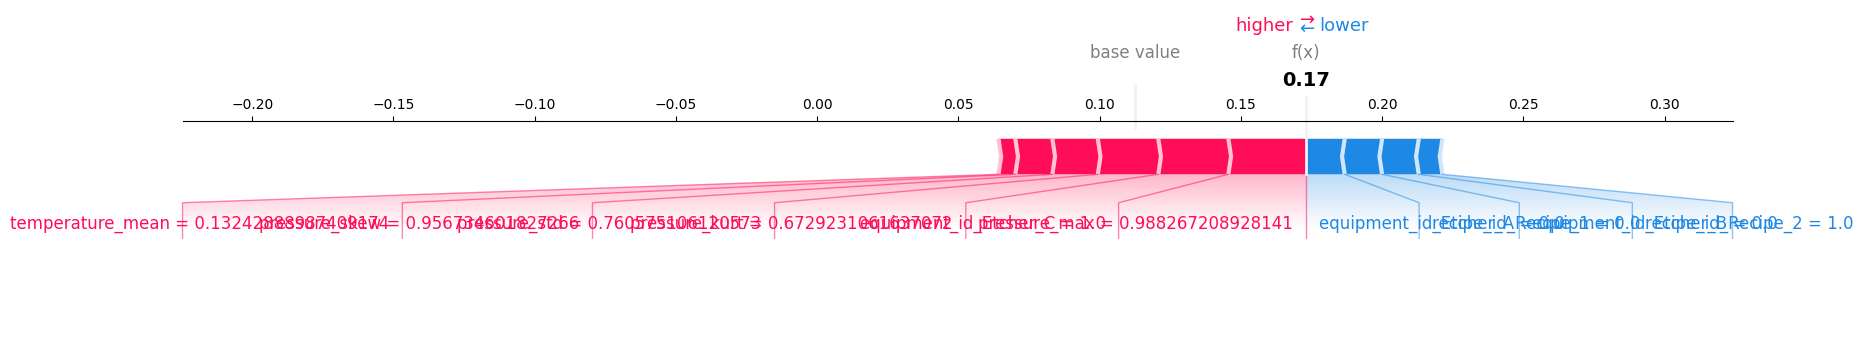

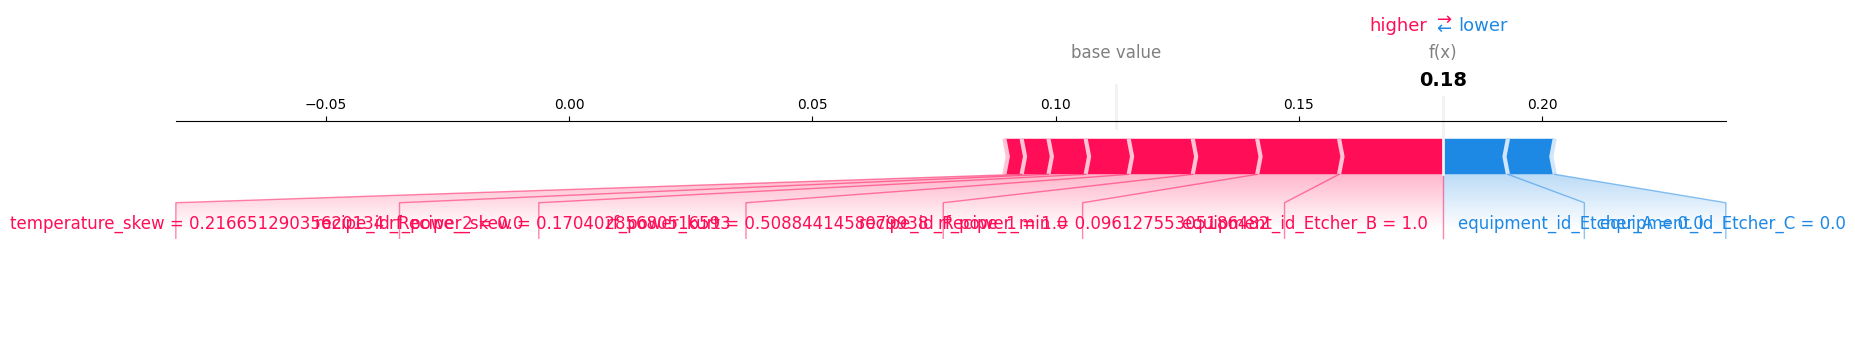


SHAP Summary Plot for all anomaly samples:
(This plot reveals which features are most important for anomaly detection overall.)
(The color represents the feature value (red is high, blue is low), and the x-axis is the SHAP value.)


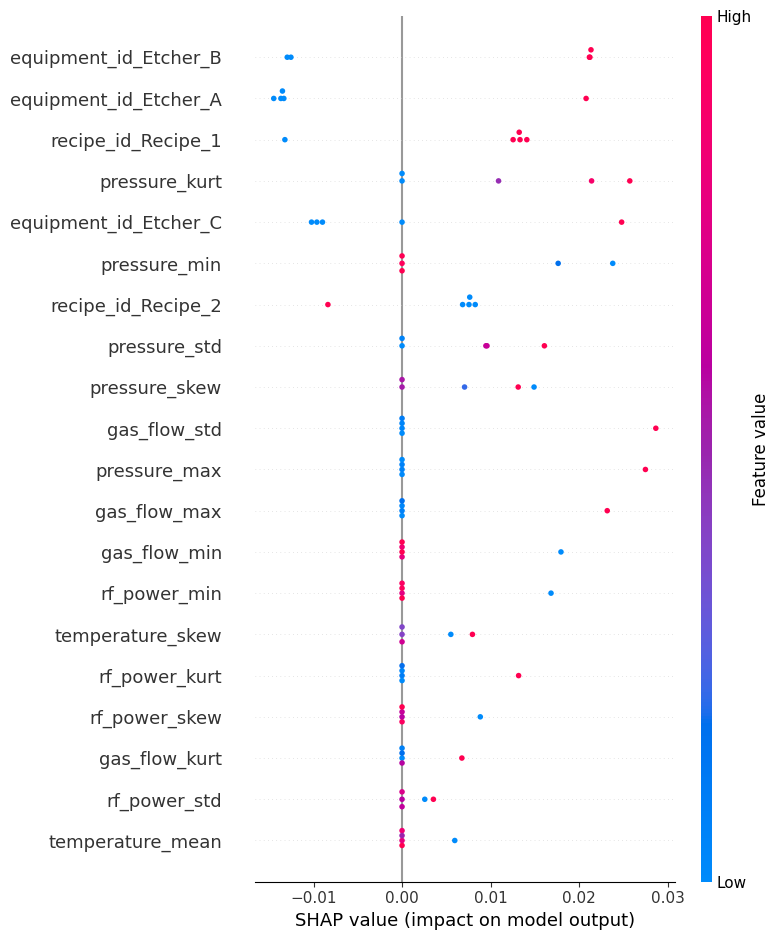

In [1]:
# ==============================================================================
# 라이브러리 임포트 (Library Imports)
# ==============================================================================
# 데이터 처리, 모델링, 시각화, 설명가능 AI에 필요한 라이브러리들을 임포트합니다.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# ==============================================================================
# 1단계: 샘플 데이터 생성 (Sample Data Generation)
# ==============================================================================
# 실제 반도체 공정 데이터를 모사하여 FDC 시계열 데이터와 MES 정적 데이터를 생성합니다.
# 정상 데이터와 함께 다양한 유형의 이상 데이터를 포함하여 현실성을 높입니다.

def generate_wafer_data(num_wafers=500, timesteps=100):
    """
    하나의 공정 스텝에 대한 웨이퍼 데이터를 생성합니다.
    - FDC: 4개의 센서(압력, RF파워, 가스, 온도)에 대한 시계열 데이터
    - MES: 각 웨이퍼의 공정 조건 및 최종 수율 정보
    """
    print(f"Generating sample data for {num_wafers} wafers...")

    # --- MES 데이터 생성 (정적 특징) ---
    wafers = []
    for i in range(num_wafers):
        wafer_id = f'WAF_{i+1:04d}'
        equipment_id = np.random.choice(['Etcher_A', 'Etcher_B', 'Etcher_C'])
        recipe_id = np.random.choice(['Recipe_1', 'Recipe_2'])
        wafers.append([wafer_id, equipment_id, recipe_id])

    mes_df = pd.DataFrame(wafers, columns=['wafer_id', 'equipment_id', 'recipe_id'])

    # --- FDC 데이터 생성 (동적 특징) ---
    fdc_data = {}
    anomaly_types = []
    final_yields = []

    for i, row in mes_df.iterrows():
        wafer_id = row['wafer_id']

        # 기본 센서 값 설정
        pressure_mean = 100
        rf_power_mean = 500
        gas_flow_mean = 200
        temp_mean = 80

        # 정상 데이터 생성
        pressure = np.random.normal(pressure_mean, 1, timesteps)
        rf_power = np.random.normal(rf_power_mean, 5, timesteps)
        gas_flow = np.random.normal(gas_flow_mean, 2, timesteps)
        temperature = np.random.normal(temp_mean, 0.5, timesteps)

        anomaly_type = 'Normal'
        final_yield = 1 # 1: 정상, 0: 불량

        # 20%의 확률로 이상 데이터 생성
        if np.random.rand() < 0.2:
            final_yield = 0
            anomaly_choice = np.random.choice(['Spike', 'Variance', 'Drift'])
            anomaly_type = anomaly_choice

            if anomaly_choice == 'Spike':
                # 특정 센서에 스파이크(순간적인 급등/급락) 발생
                spike_sensor = np.random.choice(['pressure', 'rf_power'])
                spike_idx = np.random.randint(20, 80)
                spike_magnitude = (np.random.rand() - 0.5) * 10
                if spike_sensor == 'pressure':
                    pressure[spike_idx] += pressure_mean * 0.1 * (1 if spike_magnitude > 0 else -1)
                else:
                    rf_power[spike_idx] += rf_power_mean * 0.05 * (1 if spike_magnitude > 0 else -1)

            elif anomaly_choice == 'Variance':
                # 특정 센서의 변동성(분산) 증가
                var_sensor = np.random.choice(['gas_flow', 'temperature'])
                if var_sensor == 'gas_flow':
                    gas_flow = np.random.normal(gas_flow_mean, 6, timesteps) # 표준편차 3배 증가
                else:
                    temperature = np.random.normal(temp_mean, 1.5, timesteps) # 표준편차 3배 증가

            elif anomaly_choice == 'Drift':
                # 특정 센서 값이 서서히 변하는 드리프트 현상
                drift_sensor = np.random.choice(['pressure', 'rf_power'])
                drift_amount = np.linspace(0, (np.random.rand() - 0.5) * 10, timesteps)
                if drift_sensor == 'pressure':
                    pressure += drift_amount
                else:
                    rf_power += drift_amount * 5

        fdc_data[wafer_id] = {
            'pressure': pressure,
            'rf_power': rf_power,
            'gas_flow': gas_flow,
            'temperature': temperature
        }
        anomaly_types.append(anomaly_type)
        final_yields.append(final_yield)

    mes_df['anomaly_type'] = anomaly_types
    mes_df['final_yield'] = final_yields

    print("Sample data generation complete.")
    return mes_df, fdc_data

# 데이터 생성 실행
mes_df, fdc_data = generate_wafer_data(num_wafers=500, timesteps=100)

# 생성된 데이터 확인
print("\n[Generated MES Data Sample (Top 5)]")
print(mes_df.head())
print(f"\n[Normal/Anomaly Data Distribution]\n{mes_df['anomaly_type'].value_counts()}")

# 샘플 데이터 시각화
print("\n[Sample Data Visualization] - FDC Data for Normal and Anomaly Types")
fig, axes = plt.subplots(4, 4, figsize=(20, 16), constrained_layout=True)
fig.suptitle('FDC Time Series Data Samples (Normal vs. Anomaly Types)', fontsize=20)
anomaly_types_to_plot = ['Normal', 'Spike', 'Variance', 'Drift']

for i, anomaly in enumerate(anomaly_types_to_plot):
    sample_wafer_id = mes_df[mes_df['anomaly_type'] == anomaly]['wafer_id'].iloc[0]
    axes[0, i].plot(fdc_data[sample_wafer_id]['pressure'])
    axes[0, i].set_title(f'Type: {anomaly}\n(Pressure)', fontsize=12)
    axes[1, i].plot(fdc_data[sample_wafer_id]['rf_power'])
    axes[1, i].set_title('RF Power', fontsize=12)
    axes[2, i].plot(fdc_data[sample_wafer_id]['gas_flow'])
    axes[2, i].set_title('Gas Flow', fontsize=12)
    axes[3, i].plot(fdc_data[sample_wafer_id]['temperature'])
    axes[3, i].set_title('Temperature', fontsize=12)

plt.show()


# ==============================================================================
# 2단계: 시계열 특징 공학 및 데이터 통합
# ==============================================================================
# FDC 시계열 데이터에서 통계적 특징(동적 특징)을 추출하고,
# 이를 MES 데이터(정적 특징)와 결합하여 모델링을 위한 최종 데이터셋을 구축합니다.

def feature_engineering(mes_df, fdc_data):
    """ 시계열 데이터로부터 통계적 특징을 추출합니다. """
    print("\nStarting time-series feature engineering...")

    features_list = []
    for wafer_id in mes_df['wafer_id']:
        wafer_features = {'wafer_id': wafer_id}
        for sensor, series in fdc_data[wafer_id].items():
            wafer_features[f'{sensor}_mean'] = np.mean(series)
            wafer_features[f'{sensor}_std'] = np.std(series)
            wafer_features[f'{sensor}_max'] = np.max(series)
            wafer_features[f'{sensor}_min'] = np.min(series)
            wafer_features[f'{sensor}_skew'] = pd.Series(series).skew()
            wafer_features[f'{sensor}_kurt'] = pd.Series(series).kurtosis()
        features_list.append(wafer_features)

    features_df = pd.DataFrame(features_list)
    print("Feature extraction complete.")

    # 동적 특징과 정적 특징 결합
    final_df = pd.merge(mes_df, features_df, on='wafer_id')
    print("Dynamic and static data integration complete.")
    return final_df

# 특징 공학 실행
final_df = feature_engineering(mes_df, fdc_data)

print("\n[Final Integrated Dataset Sample (Top 5)]")
print(final_df.head())


# ==============================================================================
# 3단계: 비선형 이상 탐지 (오토인코더 모델)
# ==============================================================================
# 정상 데이터만을 사용하여 오토인코더 모델을 학습하고,
# 이를 통해 새로운 데이터의 이상 점수(복원 오류)를 계산합니다.

# --- 데이터 전처리 ---
# 모델에 사용할 특징들을 선택합니다. wafer_id, anomaly_type 등은 제외합니다.
features_for_model = [col for col in final_df.columns if col not in ['wafer_id', 'anomaly_type', 'final_yield']]
categorical_features = ['equipment_id', 'recipe_id']
numerical_features = [col for col in features_for_model if col not in categorical_features]

# 범주형 데이터는 원-핫 인코딩, 수치형 데이터는 Min-Max 스케일링을 적용합니다.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough' # 처리하지 않는 컬럼은 그대로 둠
)

# 정상 데이터(final_yield=1)와 이상 데이터(final_yield=0) 분리
normal_df = final_df[final_df['final_yield'] == 1]
anomaly_df = final_df[final_df['final_yield'] == 0]

# 정상 데이터를 학습용과 검증용으로 분리
X_train, X_val = train_test_split(normal_df[features_for_model], test_size=0.2, random_state=42)

# 전체 데이터를 대상으로 전처리기(preprocessor)를 학습(fit)시킵니다.
# 이는 모든 데이터에 일관된 변환을 적용하기 위함입니다.
X = final_df[features_for_model]
preprocessor.fit(X)

# 데이터 변환
X_train_scaled = preprocessor.transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_all_scaled = preprocessor.transform(X)

print(f"\nTraining data shape: {X_train_scaled.shape}")

# --- 오토인코더 모델 정의 ---
input_dim = X_train_scaled.shape[1]
encoding_dim = int(input_dim / 2)

input_layer = Input(shape=(input_dim,))
# 인코더
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
# 잠재 공간
latent_view = Dense(int(encoding_dim / 4), activation="relu")(encoder)
# 디코더
decoder = Dense(int(encoding_dim / 2), activation='tanh')(latent_view)
decoder = Dense(encoding_dim, activation='tanh')(decoder)
# 출력층
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mae') # Mean Absolute Error 사용
autoencoder.summary()

# --- 모델 학습 ---
print("\nStarting Autoencoder model training...")
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,
    batch_size=16,
    shuffle=True,
    validation_data=(X_val_scaled, X_val_scaled),
    verbose=1 # 학습 과정 출력
).history

# 학습 손실 시각화
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 이상 점수 계산 및 임계치 설정 ---
# 학습된 모델로 전체 데이터를 재구성(복원)
X_pred_scaled = autoencoder.predict(X_all_scaled)
# 원본과 복원본의 차이(MAE)를 이상 점수로 계산
mae = np.mean(np.abs(X_all_scaled - X_pred_scaled), axis=1)
final_df['reconstruction_error'] = mae

# 학습에 사용된 정상 데이터의 복원 오류를 기반으로 임계치 설정
# (예: 정상 데이터 복원 오류의 99분위수를 임계치로 사용)
normal_train_pred = autoencoder.predict(X_train_scaled)
train_mae = np.mean(np.abs(X_train_scaled - normal_train_pred), axis=1)
threshold = np.quantile(train_mae, 0.99)

print(f"\nCalculated Anomaly Detection Threshold: {threshold:.4f}")

# 복원 오류 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(final_df[final_df['final_yield'] == 1]['reconstruction_error'], color="blue", label="Normal", kde=True, stat="density", linewidth=0)
sns.histplot(final_df[final_df['final_yield'] == 0]['reconstruction_error'], color="red", label="Anomaly", kde=True, stat="density", linewidth=0)
plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title('Reconstruction Error Distribution for Normal vs. Anomaly Data', fontsize=16)
plt.xlabel('Reconstruction Error', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 모델 평가 ---
y_true = final_df['final_yield'] == 0  # 0(불량)이면 True(이상)
y_pred = final_df['reconstruction_error'] > threshold

print("\n[Anomaly Detection Model Evaluation Results]")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

# 혼동 행렬(Confusion Matrix) 시각화
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()


# ==============================================================================
# 4단계: 원인 변수 설명 (Explainable AI with SHAP)
# ==============================================================================
# 이상으로 탐지된 데이터에 대해, 어떤 특징이 이상 판단에 큰 영향을 미쳤는지
# SHAP을 이용하여 분석하고 시각화합니다.

# SHAP는 원본 스케일의 데이터를 사용하는 것이 해석에 용이합니다.
# 전처리된 데이터를 다시 원래 스케일로 되돌리는 것은 복잡하므로,
# 여기서는 전처리된 데이터를 기반으로 설명하되, 특징 이름은 원래 이름을 사용합니다.
# SHAP Explainer를 생성합니다.
# (주의: 많은 데이터에 대해 실행 시 시간이 오래 걸릴 수 있습니다)

# 원-핫 인코딩으로 생성된 특징 이름까지 포함한 전체 특징 이름 리스트 생성
ohe_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
all_feature_names = numerical_features + ohe_feature_names

# SHAP Explainer 생성
# 복원 오류(loss) 자체를 설명하기 위해 커스텀 함수를 정의합니다.
def model_predict_loss(data):
    pred = autoencoder.predict(data)
    loss = np.mean(np.abs(data - pred), axis=1)
    return loss

# KernelExplainer는 모델의 종류에 상관없이 사용할 수 있는 Explainer입니다.
# 학습 데이터 중 일부를 배경 데이터로 사용하여 설명의 기준을 잡습니다.
background_data = shap.sample(X_train_scaled, 100) # 100개 샘플 사용
explainer = shap.KernelExplainer(model_predict_loss, background_data)

# 이상으로 탐지된 데이터 중 일부 샘플에 대해 SHAP 값 계산
anomaly_samples_scaled = preprocessor.transform(final_df[y_pred][features_for_model].head(5))
shap_values = explainer.shap_values(anomaly_samples_scaled)

print("\nStarting SHAP analysis (for top 5 anomaly samples)...")
# 분석 결과 시각화
X_anomaly_df = pd.DataFrame(anomaly_samples_scaled, columns=all_feature_names)

# 각 이상 샘플에 대한 Force Plot
print("SHAP Force Plot for each anomaly sample:")
print("(The plot shows how each feature contributed to pushing the model output from the base value (the average prediction) to the model output.)")
print("(Features pushing the prediction higher are in red, those pushing it lower are in blue.)")

for i in range(len(shap_values)):
    shap.force_plot(
        explainer.expected_value,
        shap_values[i, :],
        X_anomaly_df.iloc[i, :],
        matplotlib=True,
        show=True
    )

# 전체 이상 샘플에 대한 요약(Summary) Plot
print("\nSHAP Summary Plot for all anomaly samples:")
print("(This plot reveals which features are most important for anomaly detection overall.)")
print("(The color represents the feature value (red is high, blue is low), and the x-axis is the SHAP value.)")
shap.summary_plot(shap_values, X_anomaly_df)